# Lagged correlation of AMOC and OpenIFS variables

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.signal import welch, coherence, cwt
from scipy.signal import detrend as sp_detrend
from scipy import signal
import seaborn as sns
import string

In [2]:
def detrend(ds, dim="time"):
    return xr.apply_ufunc(
        sp_detrend,
        ds.dropna(dim),
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
    )

In [3]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
sns.set_style("ticks")

In [4]:
from dask.distributed import Client, LocalCluster, wait

In [5]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43209 instead
  expected, actual


In [6]:
client

Client Scheduler: tcp://127.0.0.1:38115 Dashboard: http://127.0.0.1:43209/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [7]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'

## Read NEMO stream functions

In [8]:
# To read
exp_list = ['FOCI_GJK001','FOCI_GJK006']
#label_list = ['Warm phase','Cold phase']
time_list = [slice('1850-01-01','2850-01-01'), slice('2850-01-01','3950-01-01')]

In [9]:
# NEMO MOC
ds_moc_all = []
for exp,time in zip(exp_list,time_list):
    moc = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*MOC.nc' % (esmdir,exp,exp)
    print(moc)
    ds_moc = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    lat = ds_moc['nav_lat'][0,:,0].data
    ds_moc_lat = ds_moc.assign_coords(lat=("y", lat)) # add latitude to stream functions
    ds_moc_all.append(ds_moc_lat)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1m*MOC.nc


In [10]:
ds_moc = xr.concat( ds_moc_all, dim='time' )

In [11]:
ds_moc

<xarray.Dataset>
Dimensions:    (time: 25200, y: 511, x: 1, depthw: 46)
Coordinates:
  * depthw     (depthw) float32 -0.0 -6.194 -12.84 ... -5.5e+03 -5.75e+03
  * time       (time) object 1850-01-16 12:00:00 ... 3949-12-16 12:00:00
    lat        (y) float32 -76.95 -76.84 -76.73 -76.61 ... 89.79 89.94 89.79
Dimensions without coordinates: y, x
Data variables:
    nav_lon    (time, y, x) float32 dask.array<chunksize=(120, 511, 1), meta=np.ndarray>
    nav_lat    (time, y, x) float32 dask.array<chunksize=(120, 511, 1), meta=np.ndarray>
    zomsfglo   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfatl   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfinp   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfind   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfpac   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfinp0  (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Partial step computation

## Read OpenIFS data

Read in monthly in case we want to look at seasonal variables

In [12]:
# OpenIFS surface
ds_sfc_1m_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/*1m*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_1m_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/*1m*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/*1m*regular_sfc.nc


In [13]:
ds_sfc_1m = xr.concat( ds_sfc_1m_all, dim='time' )

In [14]:
# OpenIFS surface
ds_sfc_1y_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_1y_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/1y/*1y*regular_sfc.nc


In [15]:
ds_sfc_1y = xr.concat( ds_sfc_1y_all, dim='time' )

In [16]:
ds_sfc_1y

<xarray.Dataset>
Dimensions:            (time: 2100, bnds: 2, lon: 192, lat: 96)
Coordinates:
  * time               (time) object 1850-07-01 06:00:00 ... 3949-07-01 06:00:00
  * lon                (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * lat                (lat) float32 -89.06 -87.19 -85.31 ... 85.31 87.19 89.06
Dimensions without coordinates: bnds
Data variables: (12/42)
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    sstk               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ci                 (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    es                 (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    tclw               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    tciw               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ...                 ...
    swvl1              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl2              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl3              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl4              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    sro                (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ssro               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    history:      Mon Nov 22 19:25:50 2021: ncks -O -7 --no-alphabetize -L 1 ...
    Conventions:  CF-1.6
    name:         ECE3_1m_18500101_regular_sfc
    description:  Created by xios
    title:        Created by xios
    timeStamp:    2021-Nov-12 19:21:56 GMT
    uuid:         0c810368-fe66-48aa-9163-86fa3ed8dac8
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    frequency:    year
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

## Compute AMOC time series

In [17]:
# What latitude to use
amoc_lat = 26.5

# Latitudes from NEMO grid
nav_lat = ds_moc_all[0]['nav_lat'][0,:,0].values

# Find j index closest to amoc_lat
amoc_j = np.argmin( np.abs(nav_lat - amoc_lat) )
print(amoc_j, nav_lat[amoc_j])

# Take max stream function at specified latitude
# Then take annual means 
amoc = ds_moc['zomsfatl'].sel(x=0,y=amoc_j).max('depthw').groupby('time.year').mean('time').compute()
amoc_anom = amoc - amoc.mean('year')    

303 26.279882


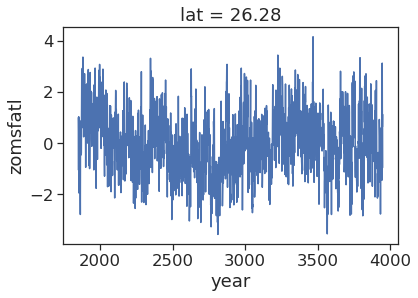

In [18]:
amoc_anom.plot()

## Define phases

In [19]:
label_list = ['Phase1','Phase2','Phase3']
#period_list = [slice('2200-01-01','2500-01-01'), slice('2600-01-01','3200-01-01'), slice('3200-01-01','3500-01-01')]
#period_list_yr = [slice(2200,2500), slice(2600,3199), slice(3200,3500)]

# New updated phases using 20-100 year bandpass
period_list = [slice('2200-01-01','2550-01-01'), slice('2550-01-01','3300-01-01'), slice('3300-01-01','3550-01-01')]
period_list_yr = [slice(2200,2550), slice(2550,3300), slice(3300,3500)]

## Lagged correlation of AMOC and OpenIFS variables

In [20]:
def lag_corr(x, y, shiftx=0, shifty=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    # Joakim: Assume we correlate AMOC and AMV. If positive AMOC anom
    # precedes positive AMV, then AMOC at year-shift is correlated with AMV at year
    # So correlation at lagx=-5 means x (AMOC) leads y (AMV). 
    if shiftx != 0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = shiftx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if shifty!=0:
        y   = y.shift(time = shifty).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean('time')
    ymean = y.mean('time')
    xstd  = x.std('time')
    ystd  = y.std('time')
    
    #4. Compute covariance along time axis
    cov   =  ((x - xmean)*(y - ymean)).sum('time')/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

In [21]:
def manylags(x, data, lags):
    
    # Loop over the phases
    if 1:
        
        # List of all correlations
        da_r = []
        da_p = []
        da_k = []
        
        # Loop over lags
        # lag < 0 -> AMOC leads
        # lag > 0 -> AMOC lags
        for lagx in lags:
            
            # Detrend
            xd = detrend(x, dim='time')
            yd = detrend(data, dim='time')

            #if lagx == 0:
            #    # Control plot
            #    xd.plot(ax=ax1[jp], label='AMOC')
            #    yd.plot(ax=ax1[jp], label='AMV')
            
            # Linear regression
            _cov, _cor, _k, _m, _p, _std = lag_corr(xd, yd, shiftx=lagx)

            # Add lag as dimension and append to list
            _cor['lag'] = lagx
            _p['lag'] = lagx
            _k['lag'] = lagx
            da_r.append(_cor)
            da_p.append(_p)
            da_k.append(_k)
        
        # Merge along lag dimension
        cor = xr.concat(da_r,dim='lag')
        slope = xr.concat(da_k,dim='lag')
        pval = xr.concat(da_p,dim='lag')
        
    return cor, slope, pval

In [30]:
variables = ['sstk','ci','msl','thf']
slope_list = []
cor_list = []

for v in variables:
    
    period = period_list[2]
    period_yr = period_list_yr[2]
    
    if v == 'thf':
        # turbulent heat flux is sensible + latent
        # scale to get W/m2
        _da = (ds_sfc_1y['sshf'] + ds_sfc_1y['slhf'])/(6.0*60*60)
        _da.name = 'shf'
    else:
        _da = ds_sfc_1y[v]
    
    # its already annual means, but we use this to change time axis to years instead of dates
    _da_y = _da.groupby('time.year').mean('time')
    
    # Running mean
    #runmean = 11
    
    # Running mean
    # Select period
    # Rename to time for the function
    #_amoc1 = _amoc.rolling(year=runmean,center=True).mean().rename({'year':'time'}).dropna('time')
    #_data1 = _data.rolling(year=runmean,center=True).mean().rename({'year':'time'}).dropna('time')
    
    # Note: It is much better to do the rolling first and select period after
    # otherwise we will have 50 years of nans in the beginning and end of each period
    # which is a loss of data for phase3 in particular
    
    # Bandpass 20-100yr
    # Subtract 100yr from 20yr lowpass
    run1, run2 = 20,100
    _amoc = (amoc_anom.rolling(year=run1,center=True).mean() - amoc_anom.rolling(year=run2,center=True).mean())
    _data = (_da_y.rolling(year=run1,center=True).mean() - _da_y.rolling(year=run2,center=True).mean())
    
    # select period and rename dimension to time
    _amoc1 = _amoc.sel(year=period_yr).rename({'year':'time'}).dropna('time').compute()
    _data1 = _data.sel(year=period_yr).rename({'year':'time'}).dropna('time').compute()
    
    cor, slope, pval = manylags(_amoc1, _data1, lags=[-30, -20, -10, -5, -2, 0, 2, 5, 10, 20, 30])
    
    cor_list.append(cor)
    slope_list.append(slope)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/facetgrid.py:392: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


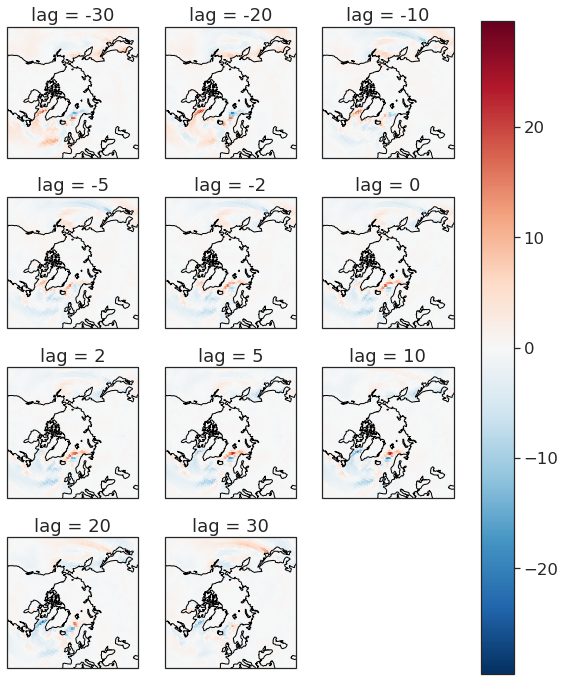

In [25]:
p = slope.plot(row='lag', col_wrap=3, 
               transform=ccrs.PlateCarree(), 
               subplot_kws={'projection':ccrs.NorthPolarStereo()})
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent([-180,180,40,90], crs=ccrs.PlateCarree())
    #ax.set_extent([0,360,30,90])

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


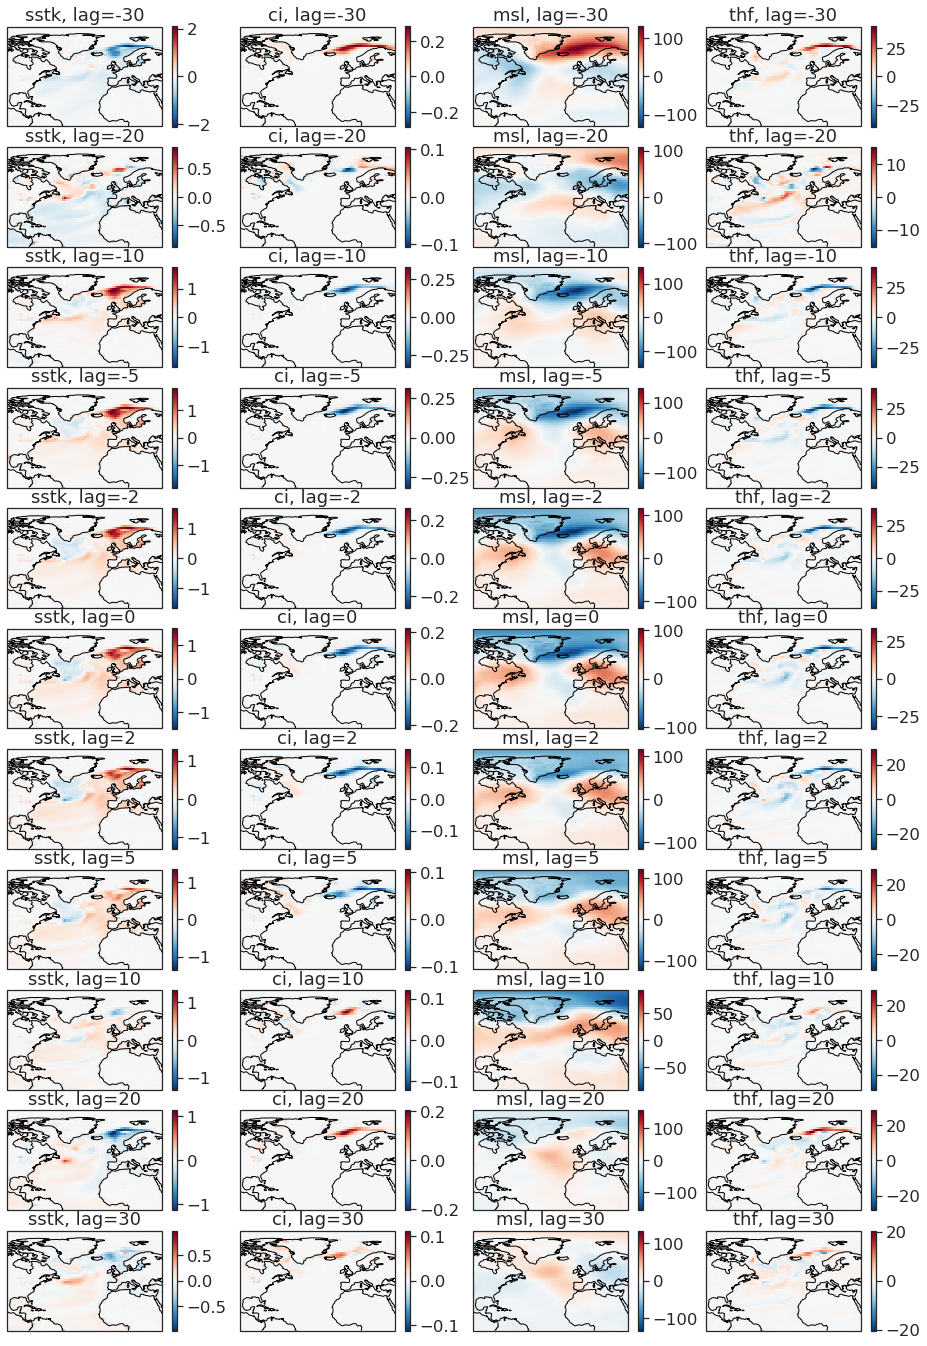

In [31]:
fig1, ax1 = plt.subplots(11, 4, figsize=(16,24), 
                         subplot_kw={'projection':ccrs.PlateCarree()})
lags = [-30, -20, -10, -5, -2, 0, 2, 5, 10, 20, 30]
for jv, (slope,cor,v) in enumerate( zip(slope_list, cor_list, variables) ):
    
    for jl,l in enumerate(lags):
        
        ax = ax1[jl,jv]
        
        slope.sel(lag=l).plot(ax=ax, 
                              rasterized=True, 
                              transform=ccrs.PlateCarree())
        
        ax.set_title('%s, lag=%d' % (v,l))
        ax.coastlines()
        ax.set_extent([-100,40,0,90])
        #ax.set_extent([-180,180,40,90], crs=ccrs.PlateCarree())
        
fig1.tight_layout()
#fig1.savefig('figures/AMOC45_sstk_ci_msl_thf_Phase3_11yrlowpass.pdf',format='pdf')
fig1.savefig('figures/AMOC26_sstk_ci_msl_thf_Phase3_20-100yrbandpass.pdf',dpi=150,format='pdf')